In [1]:
"""
TODO:
- Get at least a reasonable looking change. Maybe start with bad initial conditions.
- Gg should be symmetric
- is_inhibitory should be boolean
- BFGS cannot handle constraints nor bounds
"""
import numpy as np
import project_path
from model.neural_model import NeuralModel

def gen_random_connectome(N):
  """
  Return Gg (NxN), Gs (NxN), is_inhibitory (Nx1)
  """
  Gg = np.random.rand(N,N)
  Gs = np.random.rand(N,N)
  is_inhibitory = (np.random.rand(N) > 0.5) * 1.0
  return (Gg, Gs, is_inhibitory)

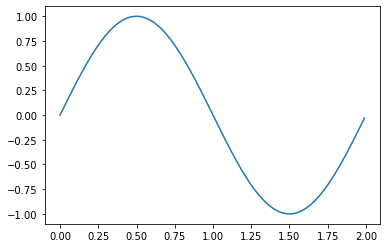

In [2]:
import pylab as plt

dt = 0.01
def get_gold_dynamics(dt):
  """
  Generate 1 period of the golden dynamics
  The return value is already discretized according to dt 
  """
  # Period length in s
  period_s = 2.0
  ts = np.arange(0, period_s, dt)
  return ts, np.sin((2 * np.pi / period_s) * ts)

ts, ys = get_gold_dynamics(dt)
plt.plot(ts, ys)

In [3]:
def ts_distance_euclidean(ts1, ts2):
  return np.linalg.norm(ts1 - ts2)
ts_distance_euclidean(np.array([1] * 5), np.array([0] * 5))

2.23606797749979

In [6]:
from sklearn.decomposition import PCA
import pdb

def unpack_param_vec(x):
  gg_vec = x[:N*N]
  gs_vec = x[N*N:2*N*N]
  gg_mat = gg_vec.reshape(N,N)
  gs_mat = gs_vec.reshape(N,N)
  is_inhibitory = x[2*N*N:]
  return gg_mat, gs_mat, is_inhibitory

def run_neural_model(N, Gg, Gs, is_inhibitory, gold_dynamics):
  # Only the first neuron is receiving constant input
  I_ext = np.array([1.0] + [0] * (N-1))
  model = NeuralModel(
    N = N,
    Gg = Gg,
    Gs = Gs,
    is_inhibitory = is_inhibitory,
    I_ext = I_ext)
  
  # Run longer than gold_dynamics to allow trajectory to stabilize
  simul_ts = len(gold_dynamics) * 2
  (v_mat, s_mat, v_normalized_mat) = model.run(simul_ts)

  # Reduce dimension of model dynamics
  pca = PCA(n_components = 1)
  projected_X = pca.fit_transform(v_normalized_mat)

  # First PCA comp, and just the last bits
  normalized_run_dyn = projected_X[len(gold_dynamics):,0]
  return normalized_run_dyn

def create_obj_fun(N, gold_dynamics):
  def obj_fun(x):
    gg_mat, gs_mat, is_inhibitory = unpack_param_vec(x)
    normalized_run_dyn = run_neural_model(N, gg_mat, gs_mat, is_inhibitory, gold_dynamics)
    error = ts_distance_euclidean(gold_dynamics, normalized_run_dyn)
    return error
  return obj_fun

Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.06s
Error before optimization = 11.80827675142391


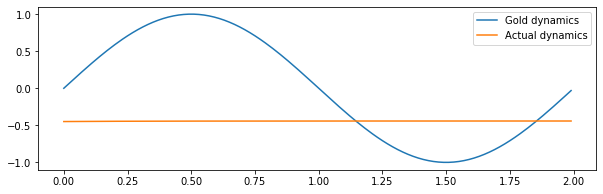

In [8]:
# Initial run
N = 5
dt = 0.01
Gg, Gs, is_inhibitory = gen_random_connectome(N)
ts, gold_dynamics = get_gold_dynamics(dt)

normalized_run_dyn = run_neural_model(N, Gg, Gs, is_inhibitory, gold_dynamics)
error = ts_distance_euclidean(gold_dynamics, normalized_run_dyn)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(ts, gold_dynamics, label = "Gold dynamics")
ax.plot(ts, normalized_run_dyn, label = "Actual dynamics")
ax.legend()
print("Error before optimization = " + str(error))

In [10]:
# Optimize
from scipy.optimize import minimize

obj_fun = create_obj_fun(N, gold_dynamics)
bnds = [(0, None)] * (2 * N**2 + N)
init_cond_arr = np.concatenate([Gg.flatten(), Gs.flatten(), is_inhibitory])

res = minimize(obj_fun, init_cond_arr, method='BFGS', bounds=bnds)
print(res)

/home/stephen/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.06s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.05s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Ti

Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.05s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.05s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Time

Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.05s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.05s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.05s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.05s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.05s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.05s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400


Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Ti

Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Ti

Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Time

Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Ti

Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.05s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Time

Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400


Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400


Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Time

Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400


Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Time

Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Ti

Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.05s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Time

Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.04s
Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.03s
Timestep 0 out of 400
Time

Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.05s
Error after optimization = 11.79775335387566


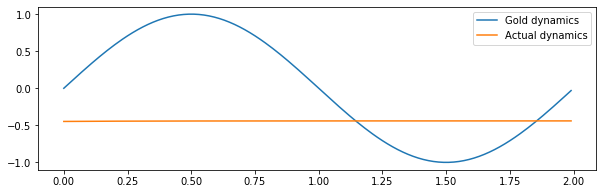

In [13]:
# Plot the optimized results
new_Gg, new_Gs, new_is_inhibitory = unpack_param_vec(res.x)

normalized_run_dyn = run_neural_model(N, new_Gg, new_Gs, new_is_inhibitory, gold_dynamics)
error = ts_distance_euclidean(gold_dynamics, normalized_run_dyn)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(ts, gold_dynamics, label = "Gold dynamics")
ax.plot(ts, normalized_run_dyn, label = "Actual dynamics")
ax.legend()
print("Error after optimization = " + str(error))